In [42]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [43]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

In [44]:

from scipy.special import softmax
from datetime import datetime
import ternary
import mpltern

## True distributions and parameters

In [45]:
# Import digitalized curves 
b0 = pd.read_csv('data/bottom_interpolated.csv', names=['gn1','density'],header=None )
l0 = pd.read_csv('data/light_interpolated.csv', names=['gn1','density'], header=None )
c0 = pd.read_csv('data/charm_interpolated.csv', names=['gn1','density'], header=None )

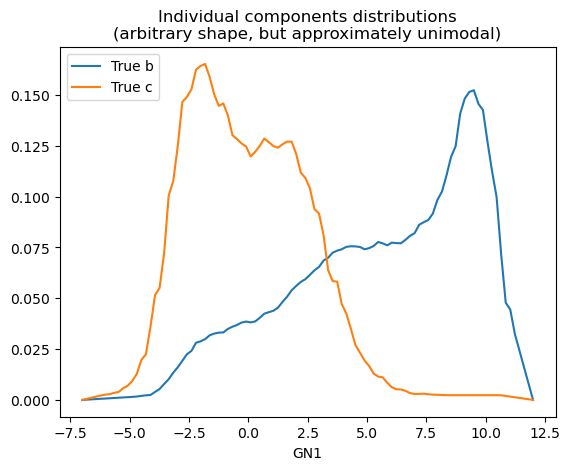

In [46]:
plt.plot(b0['gn1'], b0['density'], label='True b')
plt.plot(c0['gn1'], c0['density'], label='True c')
#plt.plot(l0['gn1'], l0['density'], label='l')
plt.xlabel('GN1')
plt.title('Individual components distributions\n(arbitrary shape, but approximately unimodal)')
plt.legend()
plt.show()

In [47]:
# parameters to sonstruct the data
pi = [0.2,0.5,0.3]  # proportion expected for each class
                    # slot0: probability of cccc
                    # slot1: probability of ccbb
                    # slot2: probability of bbbb
theta_prior = [[1.5,2], [5,2.5]] # some prior knowledge that does not match the true distributions
classes = [1,2]  # which curves to compare, 0=light, 1=charm, 2 = bottom

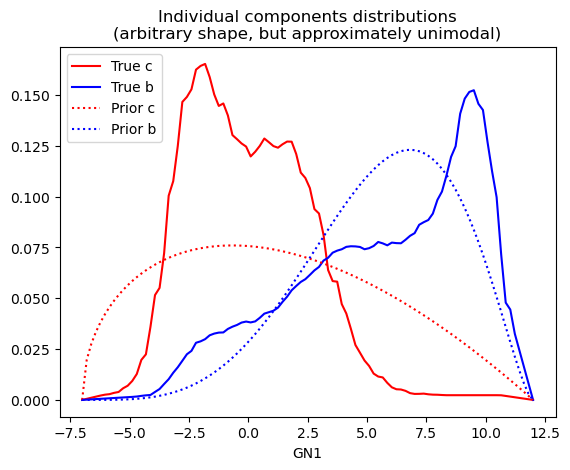

In [48]:
x0 = min(b0['gn1'])
x1 = max(b0['gn1'])
x = np.linspace(x0,x1,100)
plt.plot(c0['gn1'], c0['density'], 'r', label='True c')
plt.plot(b0['gn1'], b0['density'], 'b', label='True b')
plt.plot(x, stats.beta.pdf((x-x0)/(x1-x0), theta_prior[0][0],theta_prior[0][1])/(x1-x0), 'r:', label='Prior c')
plt.plot(x, stats.beta.pdf((x-x0)/(x1-x0), theta_prior[1][0],theta_prior[1][1])/(x1-x0), 'b:', label='Prior b')
#plt.plot(l0['gn1'], l0['density'], label='l')
plt.xlabel('GN1')
plt.title('Individual components distributions\n(arbitrary shape, but approximately unimodal)')
plt.legend()
plt.show()

## Create (synthetic) data

In [49]:
def create_data_unimode(mytext = '', N = 100, pi = pi, theta_prior = theta_prior, m=15, num_chains = 4, myseed = 10):
    # reshape true curves to m bins
    vec = np.linspace(0,99,m)
    myrows = [int(x) for x in vec]
    ctrue = c0.iloc[myrows]
    btrue = b0.iloc[myrows]
    ctrue.reset_index(drop=True, inplace=True)
    btrue.reset_index(drop=True, inplace=True)
    individual_component_c = ctrue
    individual_component_b = btrue
    individual_component_names = ['c', 'b']    

    
    # determine start, stop and step of binning
    start = min(individual_component_c['gn1'])
    stop = max(individual_component_c['gn1'])
    m = len(individual_component_c)  # just to be sure we have the correct length after thinning the lists
                                     # Here m is the number of limits in the bins, henceforh there are m-1 bins
    step = (stop - start)/(m-1)
    # Bins are subtle, one thing is the middle of each bien, and another thing is the edge of each bin
    midbins = [start+(i+1/2)*step for i in range(0,m-1)]
    edgebins = np.linspace(start,stop,m)
    # These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
    start1 = 0
    stop1 = 1
    step1 = (stop1 - start1)/(m-1)
    midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
    
    # Distributions
    prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], 
                           [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
    true_distribution = [ [midbins, [ (individual_component_c.iloc[i]['density']+individual_component_c.iloc[i+1]['density'])/2 for i in range(m-1)] ],
                          [midbins, [ (individual_component_b.iloc[i]['density']+individual_component_b.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]
    
    # Make probabilities sum 1
    for i in range(len(true_distribution)):
        tmp = sum(true_distribution[i][1])+0.0*(m-1)
        true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

    for i in range(len(prior_distribution)):
        tmp = sum(prior_distribution[i][1])+0.0*(m-1)
        prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                    # We leave room to add a small number as e.g. 0.001 to avoid a "-inf" in log_prior that does snot enter into c++ STAN code
            
    plt.plot(true_distribution[0][0], true_distribution[0][1], '-.r', label='True '+individual_component_names[0]+'-distribution')
    plt.plot(true_distribution[1][0], true_distribution[1][1], '-.b', label='True '+individual_component_names[1]+'-distribution')
    plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':r', label=individual_component_names[0]+'-prior central-value')
    plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':b', label=individual_component_names[1]+'-prior central-value')
    plt.legend()
    plt.xlim(start,stop)
    plt.xlabel('ATLAS GN1')
    plt.yticks([])
    plt.title('True versus prior distributions')
    #if save == True:
    #    plt.savefig('results/'+key+'_prior-true-distributions_di-Higgs.png')
    plt.show()    

    # We now start generating data from the true distributions
    ####################################################
    np.random.seed(myseed)
    features = 4 
    X = []  # 
    # These are to keep track of the true scores sampled from each individual component
    samples_from_individual_component_c = []
    samples_from_individual_component_b = []
    for i in range(N): 
        # class0 0000 = cccc
        # class1 0011 = ccbb (any order)
        # class2 1111 = bbbb 
        myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1) # draw the class number of the i-th datapoint
        if myclass == 0:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[0][1]) ) # draw 'feature' numbers from the corresponding true_distribution
            samples_from_individual_component_c = samples_from_individual_component_c + tmp
            X.append([myclass]+ tmp)     
        elif myclass == 1:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c and 2 x b
            z = np.random.randint(6)
            c1, c2, b1, b2 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
            sampled = [ [c1,c2,b1,b2], [c1,b1,c2,b2], [c1,b1,b2,c2], [b1,c1,c2,b2],  [b1,c1,b2,c2], [b1,b2,c1,c2] ]
            samples_from_individual_component_c = samples_from_individual_component_c + [c1, c2]
            samples_from_individual_component_b = samples_from_individual_component_b + [b1, b2]
            X.append([myclass]+sampled[z])
        elif myclass == 2:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[1][1]) ) 
            samples_from_individual_component_b = samples_from_individual_component_b + tmp                        
            X.append([myclass]+ tmp)     

    X=np.array(X)        
    X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])
    #####################################################
    
    # count how many of each jet class there are in each bin    
    tmp0 = []
    tmp1 = []
    for k in range(1,m):    
        tmp0.append([k,samples_from_individual_component_c.count(k)])
        tmp1.append([k,samples_from_individual_component_b.count(k)])
    tot0 = sum([x[1] for x in tmp0])
    tot1 = sum([x[1] for x in tmp1])
    samples_from_individual_component_c = [[x[0], x[1]/tot0] for x in tmp0]
    samples_from_individual_component_b = [[x[0], x[1]/tot1] for x in tmp1]
    
    # plot real data sampled
    plt.plot([x[0] for x in samples_from_individual_component_c], [x[1] for x in samples_from_individual_component_c],  label=individual_component_names[0])
    plt.plot([x[0] for x in samples_from_individual_component_b], [x[1] for x in samples_from_individual_component_b],  label=individual_component_names[1])
    plt.title('Real data ('+str(N)+' events): scores stacked together by true individual components')
    plt.xticks(range(1,m))
    plt.show()
    

    muc = list(true_distribution[0][1]) 
    mub = list(true_distribution[1][1])

  
    # define mydata to run the model
    #my_data = {'m': m, 'N': len(X), 'muc': muc,  'mub': mub, 'score': list(X[:,1:]) }
    my_data = {'m': m, 'N': len(X), 'score': list(X[:,1:]) }
       
    return samples_from_individual_component_c, samples_from_individual_component_b,  muc, mub, X0, my_data
    

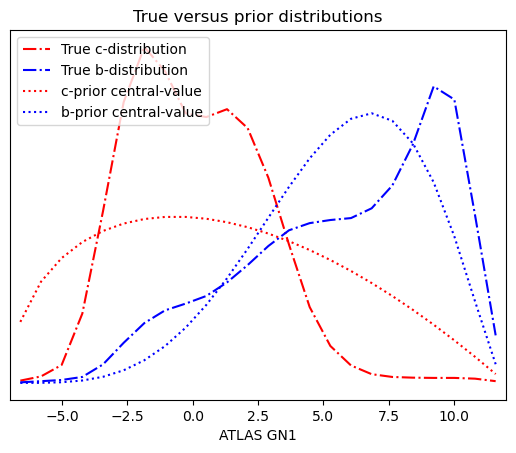

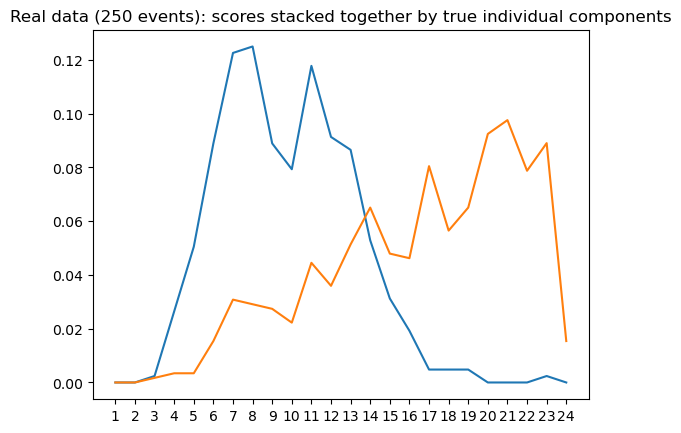

In [50]:
pi = [0.2, 0.5, 0.3] # cccc. ccbb, bbbb
samples_from_individual_component_c, samples_from_individual_component_b,  muc, mub, X0, my_data = create_data_unimode(N=250, m=25, pi=pi, myseed=0)

In [51]:
X0

,class,xn0,xn1,xn2,xn3
0,2,19,18,16,20
1,2,23,16,21,18
2,2,8,9,6,22
3,2,23,21,17,21
4,2,11,23,18,16
...,...,...,...,...,...
245,1,19,7,10,16
246,1,12,20,21,8
247,2,20,22,19,21
248,2,11,19,16,23


## STAN Bayesian Models

#### Unimodal

In [52]:
unimodal = """
functions {
  real partial_sum(array[,] int score_slice,
                   int start, int end,
                   vector yc,
                   vector yb,
                   vector theta)
{
    real permutation_factor = 1.0/6;
    real partial_target = 0;
    vector[3] lp;
    vector[6] lp2;
    int slice_length = end-start+1;

    for (k in 1:slice_length)
     {
     lp2[1] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[2] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[3] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
     lp2[4] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[5] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
     lp2[6] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]];

     lp[1] = log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
     lp[2] = log_sum_exp(lp2);
     lp[3] = log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]];

     partial_target += log_mix(theta, lp);  // theta.1: cccc
                                            // theta.2: ccbb
                                            // theta.3: bbbb
     }

    return partial_target;
  }
}


data {
  int<lower=1> m;  // steps in the discretization
  int<lower=1> N;  // data points
  array[N,4] int<lower=1, upper=m> score;  // b-tagging scores

}


parameters {
  vector<lower=0>[m-2] a_c;	
  simplex[m-1] w_c_mode;
  vector<lower=0>[m-2] a_b;	
  simplex[m-1] w_b_mode;
  simplex[3] theta; // mixture coefficient for the 3 classes
}



transformed parameters{
  ordered[2] y8;   // this parameter will reinforce correct labelling, avoiding label switch. Because the 8th bin class0 is greater than class1 always
  ordered[2] y20;

  vector[m-1] p_c;  
  p_c=rep_vector(0.0, m-1);  					// creates null vector of size K
  for(k in 1:m-1){
    vector[m-1] logp_c;
    vector[m-2] sign_j;
    sign_j = rep_vector(-1.0,m-2);				// creates vector smaller in one element, with all components equal to -1
    if (k>=2)
      sign_j[1:(k-1)] = rep_vector(1.0,k-1);			// put +1 up to k-1, and leave others in -1
    logp_c = append_row(0.0,   cumulative_sum (sign_j .* a_c));	// each component is the sum of all the previous one in cumulative_sum 
								// (kind of an integral).  x .*= y means x = x * y element-wise.
    p_c =  p_c + softmax(logp_c)  *  w_c_mode[k];                 // Here there is some magic. You are doing a w_mode-weighted-average of 

   }


  vector[m-1] p_b;  
  p_b=rep_vector(0.0, m-1);  					
  for(k in 1:m-1){
    vector[m-1] logp_b;
    vector[m-2] sign_b;
    sign_b = rep_vector(-1.0,m-2);				
    if (k>=2)
      sign_b[1:(k-1)] = rep_vector(1.0,k-1);			
    logp_b = append_row(0.0,   cumulative_sum (sign_b .* a_b));	
								
    p_b =  p_b + softmax(logp_b)  *  w_b_mode[k];                 
   }								
  y8[1] = p_b[8];			// let's try this to avoid label switch
  y8[2] = p_c[8];
		
  y20[1] = p_c[20];
  y20[2] = p_b[20];		
}

model {
  int grainsize = 1;
  theta ~ dirichlet([1,1,1]);
  a_c ~ normal(0,0.5);
  a_b ~ normal(0,0.5);
  w_b_mode ~ dirichlet( rep_vector(1.0/(m-1), m-1) );  
  w_c_mode ~ dirichlet( rep_vector(1.0/(m-1), m-1) );  

  target += reduce_sum(partial_sum, score, grainsize, p_c, p_b, theta);


}
"""

## Inference

In [53]:
model = stan.build(unimodal, data=my_data, random_seed=0);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_rqf1pld_/model_74v6xkfk.stan', line 102, column 12: The
    variable partial_sum may not have been assigned a value before its use.


In [54]:
%%time
fit = model.sample(num_chains=4, num_samples=1000, delta=0.8)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_74v6xkfk_namespace::log_prob: y8 is not a valid ordered vector. The element at 2 is 0.00971681, but should be greater than the previous element, 0.0456578 (in '/tmp/httpstan_mcl81rz5/model_74v6xkfk.stan', line 57, column 2 to column 16)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_74v6xkfk_namespace::log_prob: y8 is not a valid ordered vector. The element at 2 is 0.0688568, but should be greater than the previous element, 0.0916376 (in '/tmp/httpstan_mcl81rz5/model_74v6xkfk.stan', line 57, column 2 to column 16)
  Gradient evaluation took 0.002306 seconds
  1000 transitions using 10 leapfrog steps per transition would take 23.06 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis pro

CPU times: user 413 ms, sys: 52.7 ms, total: 466 ms
Wall time: 444 ms


In [55]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a_c.1,a_c.2,a_c.3,...,p_b.15,p_b.16,p_b.17,p_b.18,p_b.19,p_b.20,p_b.21,p_b.22,p_b.23,p_b.24
draws,,,,,,,,,,,,,,,,,,,,,
0,-3103.758163,0.965315,0.006884,9.0,511.0,0.0,3144.442992,0.452221,1.425148,1.107324,...,0.037842,0.040136,0.048947,0.070770,0.073824,0.087879,0.111426,0.130065,0.101438,0.021235
1,-3131.431566,0.981430,0.007115,9.0,511.0,0.0,3169.335438,0.343408,0.712404,1.396024,...,0.076931,0.068571,0.069978,0.074318,0.082119,0.088863,0.084234,0.081892,0.072514,0.030861
2,-3099.457497,0.947100,0.007391,9.0,511.0,0.0,3148.460974,0.108173,0.534090,1.151898,...,0.066566,0.053983,0.051451,0.058186,0.075692,0.088075,0.110956,0.078391,0.053246,0.025952
3,-3108.445850,0.996810,0.006210,9.0,511.0,0.0,3152.041731,0.862892,0.545071,1.612837,...,0.060986,0.065316,0.065678,0.068046,0.082658,0.116633,0.097387,0.089299,0.073886,0.035749
4,-3098.552539,0.813301,0.006884,8.0,445.0,1.0,3151.643207,0.390472,0.665565,1.038303,...,0.068074,0.056615,0.058903,0.060784,0.066411,0.090170,0.102441,0.088613,0.085321,0.034637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-3121.761284,0.966537,0.006210,6.0,107.0,1.0,3172.605253,0.833503,0.443223,1.129881,...,0.058328,0.058791,0.066109,0.069682,0.070841,0.095498,0.080062,0.079519,0.077362,0.026265
3996,-3111.876953,0.975198,0.006884,9.0,511.0,0.0,3161.585536,1.262356,0.977682,1.270873,...,0.055384,0.065087,0.068770,0.070024,0.083929,0.105622,0.111665,0.090217,0.112895,0.044758
3997,-3131.583044,0.987923,0.007115,9.0,577.0,1.0,3175.348415,0.145605,0.385295,0.925244,...,0.061366,0.056530,0.058639,0.060111,0.066146,0.091636,0.085351,0.083956,0.068470,0.016241


In [32]:
df.to_pickle('data/unimodal_run_df.pickle')

In [33]:
#pd.read_pickle('data/unimodal_run_df.pickle')

## Diagnostics

In [56]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_b[0],0.440,0.312,0.001,0.986,0.007,0.005,1211.0,850.0,1.00
a_b[1],0.506,0.339,0.003,1.103,0.009,0.006,1122.0,691.0,1.00
a_b[2],0.508,0.349,0.006,1.122,0.008,0.006,1343.0,984.0,1.00
a_b[3],0.419,0.303,0.000,0.956,0.009,0.007,755.0,736.0,1.00
a_b[4],0.442,0.309,0.001,0.991,0.008,0.006,995.0,714.0,1.00
...,...,...,...,...,...,...,...,...,...
w_c_mode[23],0.001,0.005,0.000,0.006,0.000,0.000,1680.0,1163.0,1.00
y20[0],0.010,0.007,0.001,0.022,0.000,0.000,875.0,772.0,1.00
y20[1],0.094,0.016,0.068,0.124,0.000,0.000,1027.0,1788.0,1.00
y8[0],0.014,0.007,0.002,0.027,0.000,0.000,1036.0,1438.0,1.00


## Analyze posterior

#### Marginalized fractions

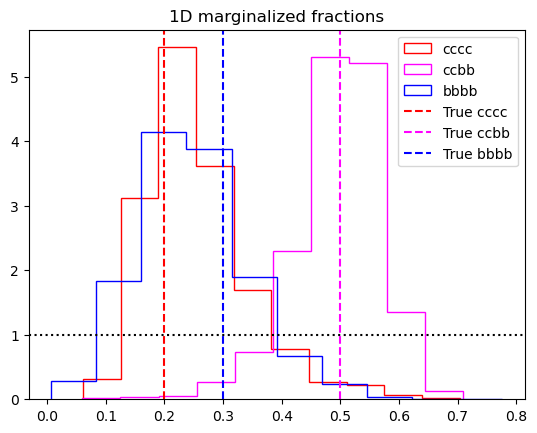

In [57]:
plt.hist(df['theta.1'], histtype='step', density=1, color='red', label='cccc')
plt.hist(df['theta.2'], histtype='step', density=1, color='magenta', label='ccbb')
plt.hist(df['theta.3'], histtype='step', density=1, color='blue',  label='bbbb')
plt.axvline(pi[0], color='red', linestyle='dashed', label='True cccc')
plt.axvline(pi[1], color='magenta', linestyle='dashed', label='True ccbb')
plt.axvline(pi[2], color='blue', linestyle='dashed', label='True bbbb')
plt.axhline(1, color='black', linestyle='dotted')
plt.legend()
plt.title('1D marginalized fractions')
plt.show()

#### Recovering the individual components

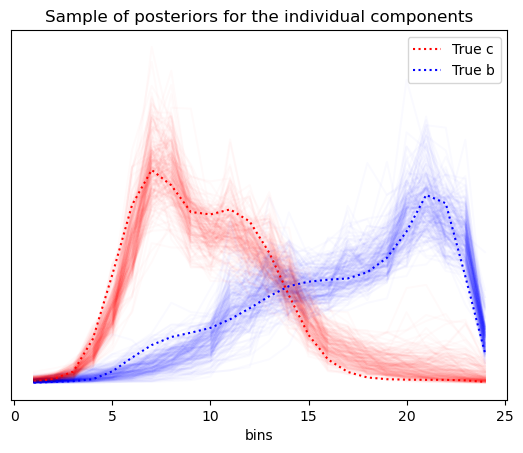

In [58]:
m = my_data['m']
x = range(1,m)
for n in range(200):
    i = np.random.randint(1,len(df))
    y = [df.iloc[i]['p_b.'+str(j)] for j in range(1,m)]
    plt.plot(x,y,'b-', alpha=0.02)
    y = [df.iloc[i]['p_c.'+str(j)] for j in range(1,m)]
    plt.plot(x,y,'r-', alpha=0.02)
plt.plot(x,muc, 'r:', label='True c')
plt.plot(x,mub, 'b:', label='True b')
plt.yticks([])
plt.xlabel('bins')
plt.title('Sample of posteriors for the individual components')
plt.legend()
plt.show()

#### Recovering the NON-marginalized fractions

The fractions are 3 numbers that add to 1, henceforth they live in the 3D simplex, which is a 2D triangle.  We use the ternary library to visualize the corresponding results.

In [59]:
mydata = df[['theta.1','theta.2','theta.3']]
mydata = np.round(mydata,2)
mydata[:2]

parameters,theta.1,theta.2,theta.3
draws,,,
0,0.26,0.51,0.23
1,0.23,0.51,0.26


In [60]:
# We bin the 3-dimensional simplex
# We create a dataframe with 3 columns for each class, and a 4th column indicating how many samples lie in the corresponding bin
tmp = []
for i in range(101):
    for j in range(101-i):
        tmp.append([i/100,j/100])
ternary_data = pd.DataFrame(tmp, columns=['cccc','ccbb'])  
ternary_data['bbbb'] = np.round([1]*len(ternary_data) - ternary_data['cccc'] - ternary_data['ccbb'],2) # complete third column in such a way that all three columns add to 1
ternary_data['value'] = [0.0] * len(ternary_data)        
total = len(mydata)  # how many bins in the simplex
delta = 1/total  # This is how much each sample of the posterior adds to each bin in such a way that after allocating all the posterior samples we sum of all bins add to 1
ternary_data[:3]

,cccc,ccbb,bbbb,value
0,0.0,0.00,1.00,0.0
1,0.0,0.01,0.99,0.0
2,0.0,0.02,0.98,0.0


In [61]:
# We fill the binned simplex with the samples of the posterior
for k in range(total):
    ternary_data.loc[(ternary_data['cccc'] == mydata.iloc[k]['theta.1']) & (ternary_data['ccbb'] == mydata.iloc[k]['theta.2']),['value']] += delta        

In [62]:
# Compute the probability at the true bin
prob_true = np.round(ternary_data[(ternary_data['cccc'] == pi[0]) & (ternary_data['ccbb'] == pi[1])]['value'].values[0],4)
# The probability under an agnostic uniform prior is
prob_prior = np.round(1/len(ternary_data),5)
print('Prob @ true bin before inferring:', prob_prior,'\nProb @ true bin after inferring:', prob_true,'\nEnhancement factor:', np.round(prob_true/prob_prior,1))

Prob @ true bin before inferring: 0.00019 
Prob @ true bin after inferring: 0.0038 
Enhancement factor: 20.0


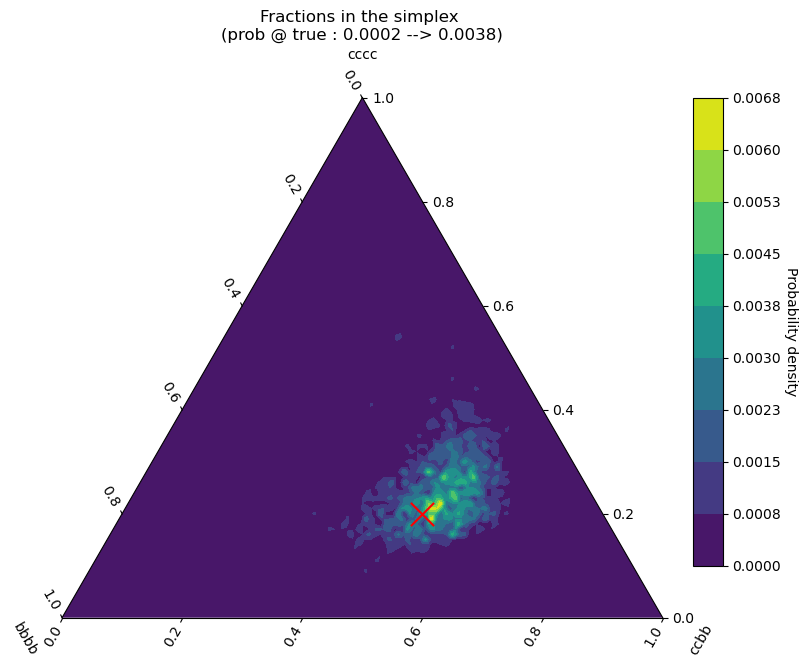

In [63]:
vmin = 0.0
vmax = max(ternary_data['value'])
levels = np.round(np.linspace(vmin, vmax, 10),4)

fig = plt.figure(figsize=(7.75, 7.4))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)
plot_number = 0
ax = fig.add_subplot(1,1, 1, projection='ternary')
cs = ax.tricontourf(ternary_data['cccc'], ternary_data['bbbb'], ternary_data['ccbb'], ternary_data['value'], levels=levels)
ax.set_tlabel('cccc')
ax.set_llabel('bbbb')
ax.set_rlabel('ccbb')
ax.taxis.set_label_position('corner')
ax.laxis.set_label_position('corner')
ax.raxis.set_label_position('corner')        
ax.set_title('Fractions in the simplex \n(prob @ true : '+str(np.round(1/len(ternary_data),4))+' --> '+str(prob_true)+')')        
ax.scatter([pi[0]],[pi[2]],[pi[1]], s=280, color='red', marker='x')
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar = fig.colorbar(cs, cax=cax)
colorbar.set_label('Probability density', rotation=270, va='baseline')
#colorbar.remove()
plt.show()        